Datasets & DataLoaders
===================

Код для обработки объектов выборки может быть запутанным и сложным в обслуживании, в идеале мы бы хотели, чтобы наш код обработки данных (data processing) был отделен от нашего кода обучения модели для лучшей читабельности и модульности. В Pytorch существует два примитива данных: ``torch.utils.data.DataLoader`` и ``torch.utils.data.Dataset``, которые позволяют использовать предварительно загруженные наборы данных, а также ваши собственные данные. Набор данных - `Dataset`, хранит объекты (samples) и соответствующие им ответы (labels), а загрузчик данных - `DataLoader` делает итерируемую обертку над `Dataset`, чтобы обеспечить легкий доступ к каждому объекту данных.

Библиотеки PyTorch предоставляют ряд предварительно загруженных датасетов (таких как FashionMNIST), которые являются подклассами ``torch.utils.data.Dataset`` и реализуют функции, специфичные для определенных данных.

Их можно использовать для создания и тестирования вашей модели. датасеты можно найти здесь:

1. Image Datasets <https://pytorch.org/vision/stable/datasets.html>
2. Text Datasets <https://pytorch.org/text/stable/datasets.html>
3. Audio Datasets <https://pytorch.org/audio/stable/datasets.html>




Загрузка Dataset
-------------------
В качестве примера рассмотрим загрузку датасета Fashion-MNIST из TorchVision. 

Fashion-MNIST - это датасет, который состоит из тренировочной (60к объектов) и тестовой (10к объектов) выборки. Каждый объект имеет изображение в градациях серого размером 28х28 пикселей и метку (один из 10 классов от 0 до 9)


Параметры:
 - ``root`` - путь, где хранятся train/test данные,
 - ``train`` - флаг, указывающий на тип данных,
 - ``download=True`` - скачать данные в ``root``, если их там нет.
 - ``transform`` and ``target_transform`` -  преобразование объекта и ответа.

In [4]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Итерация и визуализация по Dataset
-----------------

Мы можем индексировать ``Datasets`` вручную, как список: ``training_data[index]``.
Мы используем ``matplotlib`` для визуализации некоторых объектов наших тренировочных данных.

Чтобы не умирало ядро:
~~~~~~~~~~~~~~

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [6]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [8]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

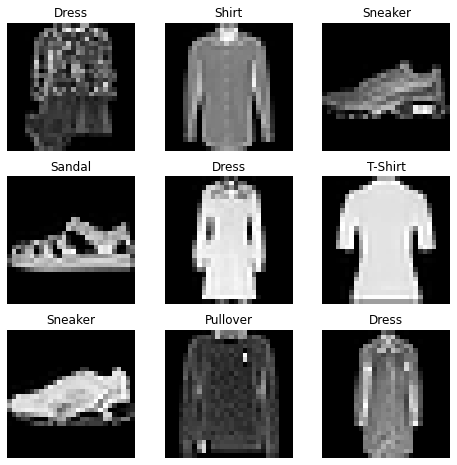

In [12]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
    # случайным образом выбириаем какой-нибудь объект из выборки
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

..
 .. figure:: /_static/img/basics/fashion_mnist.png
   :alt: fashion_mnist



--------------




Создание собственного кастомного датасета
---------------------------------------------------

Для создания нового кастомного Dataset класса необходимо обязательно реализовать три функции:

1. `__init__`
2. `__len__`
3. `__getitem__`

Ниже представлен пример. Изображения FashionMNIST хранятся в каталоге `img_dir`, а их метки хранятся отдельно в CSV-файле `annotations_file`.

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        # таблица, название файла - метка 
        self.img_labels = pd.read_csv(annotations_file)
        # папка с изображениями
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Функция __init__ запускается один раз при создании экземпляра класса. Мы инициализируем каталог, содержащий изображения, файл с метками и оба преобразования (подробнее в ноутбуке ***04_transforms_tutorial***).

Содержимое labels.csv выглядит так:

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9


In [16]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

Функция __len__ возвращает количество объектов в датасете.

Пример:

In [17]:
def __len__(self):
    return len(self.img_labels)

Функция __getitem__ загружает и возвращает один объект выборки с заданным индексом ``idx``.

На основе индекса происходит идентификация изображения на диске, затем изображение конвертируется в тензор с помощью ``read_image``, извлекается соотстветствующая метка для изображения и вызывается функция преобразования (если она имеется). По итогу возвращается кортеж из изображения в виде тензора и метки.

In [18]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

--------------




Подготовка ваших данных для обучения с DataLoaders
-------------------------------------------------

``Dataset`` извлекает признаки и метки одного объекта за один раз. При обучении модели, мы обычно хотим отправлять объекты батчами (минипакетами), перетасовывать данные каждую эпоху, дабы уменьшить вероятность переобучения модели и использовать "многопроцессорную обработку" Python для ускорения поиска данных.

``DataLoader`` - итерируемый объект, который абстрагирует описанную выше сложнсть для нас в простом API. Объекты датасета разбиваются на батчи и получается, что DataLoader это контейнер батчей. 

In [19]:
# Используем Dataset выборки в DataLoader
from torch.utils.data import DataLoader

batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [24]:
train_dataloader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [34]:
len(train_dataloader)

938

In [35]:
len(train_dataloader) * batch_size

60032

Итерирование с помощью  DataLoader
--------------------------


Мы загрузили датасет в ``DataLoader`` и теперь может перебирать данные датасета по мере необходимости.

Каждая приведенная ниже итерация возвращает батч train_features и train_labels (содержащий ``batch_size=64`` признаков и меток соответственно).

Поскольку мы указали ``shuffle=True``, после того, как мы перебираем все пакеты, данные перемешиваются (для более точного управления порядком загрузки данных взгляните на `Samplers` <https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler>).

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


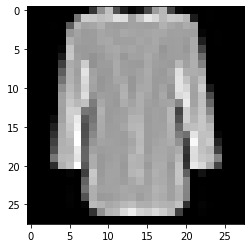

Label: 6


In [37]:
# Визуализация изображения и метки.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

--------------




Для изучения
--------------
- torch.utils.data API https://pytorch.org/docs/stable/data.html



---